<a href="https://colab.research.google.com/github/abrilvj/lol-data-analysis/blob/main/ds_lol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install riotwatcher

**CONFIGURACIONES**

In [ ]:
import pandas as pd
import requests
from riotwatcher import LolWatcher, ApiError
from google.colab import userdata # Para leer tu API Key de forma segura
import time

# --- CONFIGURACIÓN ---
api_key = "RGAPI-2cf141c8-cb45-480a-aece-86726b4deeb1" #userdata.get('RIOT_API_KEY')
watcher = LolWatcher(api_key)
region_plataforma = 'la2' # LAS
region_ruteo = 'americas'

def obtener_puuid_manual(name, tag, key):
    url = f"https://{region_ruteo}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{name}/{tag}"
    headers = {"X-Riot-Token": key}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()['puuid']
    else:
        print(f"❌ Error al buscar a {name}#{tag}: {response.status_code}")
        return None


In [ ]:
!pip install --upgrade riotwatcher

**GENERAR DATASET**

In [ ]:
import requests

test_key = "RGAPI-2cf141c8-cb45-480a-aece-86726b4deeb1" # Poné tu llave nueva acá
test_url = "https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/RiotGames/LAS"
test_headers = {"X-Riot-Token": test_key}

res = requests.get(test_url, headers=test_headers)

if res.status_code == 200:
    print("✅ ¡Llave válida! Ya podés correr el script principal.")
elif res.status_code == 401:
    print("❌ La llave sigue siendo inválida o expiró.")
elif res.status_code == 403:
    print("❌ Error 403: Llave correcta pero no tenés permisos (revisá si aceptaste los términos en el portal).")
else:
    print(f"Error {res.status_code}: {res.text}")

✅ ¡Llave válida! Ya podés correr el script principal.


In [ ]:
# Lista de tus cuentas (puedes poner las que quieras)
mis_cuentas = [
    {"nombre": "Gulp", "tag": "3921", "label": "Main (gulp)"},
    {"nombre": "3JcA", "tag": "333", "label": "Secundaria"},
    {"nombre": "hARAkiRi", "tag": "00100", "label": "Secundaria"},
    {"nombre": "I Qiyana I", "tag": "LAS", "label": "Secundaria"},
    {"nombre": "The Boy Savior 3", "tag": "Ekko", "label": "Secundaria"}
]

data_final = []

print("Iniciando extracción...")

for cuenta in mis_cuentas:
    print(f"Buscando datos para: {cuenta['nombre']}...")

    # Usamos la función manual aquí
    puuid = obtener_puuid_manual(cuenta['nombre'], cuenta['tag'], api_key)

    if puuid:
        try:
            # Una vez que tenemos el PUUID, el resto del watcher sí suele funcionar
            match_ids = watcher.match.matchlist_by_puuid(region_ruteo, puuid, count=10, queue=420) # queue 420 es solo q

            for m_id in match_ids:
                match = watcher.match.by_id(region_ruteo, m_id)
                duracion_min = match['info']['gameDuration'] / 60

                # 1. Extraer stats del jugador
                for p in match['info']['participants']:
                    if p['puuid'] == puuid:

                        # --- NUEVA LÓGICA DE EQUIPO ---
                        # Buscamos el equipo (100 o 200) que coincide con el del jugador
                        my_team = next(t for t in match['info']['teams'] if t['teamId'] == p['teamId'])
                        obj = my_team['objectives']
                        # ------------------------------

                        data_final.append({
                            'cuenta': cuenta['label'],
                            'campeon': p['championName'],
                            'win': 1 if p['win'] else 0,
                            'kda': (p['kills'] + p['assists']) / max(1, p['deaths']),
                            'oro_por_minuto': p['goldEarned'] / duracion_min,
                            'daño_por_minuto': p['totalDamageDealtToChampions'] / duracion_min,
                            'danio_total': p['totalDamageDealtToChampions'],
                            'cs_total': p['totalMinionsKilled'] + p['neutralMinionsKilled'],
                            'vision_score': p['visionScore'],
                            'duracion_partida': duracion_min,
                            'surrender': p['gameEndedInSurrender'],
                            'remake': p['gameEndedInEarlySurrender'],
                            'rol': p['teamPosition'],
                            'rol real': p['individualPosition'],
                            'participacion': p.get('challenges', {}).get('killParticipation', None),


                            # --- STATS DE EQUIPO (Lo que pediste) ---
                            'team_baron': obj['baron']['kills'],
                            'team_dragon': obj['dragon']['kills'],
                            'team_heraldo': obj['riftHerald']['kills'],
                            'team_grubs': obj.get('horde', {}).get('kills', 0), # Larvas del vacío
                            'team_atakhan': obj.get('atakhan', {}).get('kills', 0),
                            'team_soul': 1 if obj['dragon']['kills'] >= 4 else 0, # Alma de dragón
                            # ----------------------------------------
                        })
                time.sleep(1.2) # Evitar que Riot nos bloquee

            print(f"✅ {cuenta['label']} procesada.")

        except Exception as e:
            print(f"Ocurrió un error con las partidas: {e}")

# Convertir a DataFrame de Pandas
df = pd.DataFrame(data_final)
print("\n¡Listo! Así se ven tus datos:")
df.head()

Iniciando extracción...
Buscando datos para: Gulp...
✅ Main (gulp) procesada.
Buscando datos para: 3JcA...
✅ Secundaria procesada.
Buscando datos para: hARAkiRi...
✅ Secundaria procesada.
Buscando datos para: I Qiyana I...
✅ Secundaria procesada.
Buscando datos para: The Boy Savior 3...
✅ Secundaria procesada.

¡Listo! Así se ven tus datos:


,cuenta,campeon,win,kda,oro_por_minuto,daño_por_minuto,danio_total,cs_total,vision_score,duracion_partida,...,rol real,participacion,personal_atakhan,personal_baron,team_baron,team_dragon,team_heraldo,team_grubs,team_atakhan,team_soul
0,Main (gulp),Mordekaiser,0,0.272727,339.692853,867.395157,24475,165,18,28.216667,...,TOP,0.157895,0,0,0,0,0,2,0,0
1,Main (gulp),Ekko,0,1.333333,377.556371,772.606188,24556,165,22,31.783333,...,MIDDLE,0.387097,0,0,0,1,1,0,0,0
2,Main (gulp),Leblanc,0,2.600000,418.860104,849.395509,24590,201,20,28.950000,...,MIDDLE,0.464286,0,0,0,0,0,3,0,0
3,Main (gulp),Viktor,0,1.400000,376.037515,954.407972,27137,162,15,28.433333,...,MIDDLE,0.538462,0,0,0,0,0,0,0,0
4,Main (gulp),Sylas,1,2.000000,446.573816,857.548747,25655,153,23,29.916667,...,MIDDLE,0.408163,0,0,1,4,0,2,1,1


In [ ]:
df

,cuenta,campeon,win,kda,oro_por_minuto,daño_por_minuto,danio_total,cs_total,vision_score,duracion_partida,...,rol real,participacion,personal_atakhan,personal_baron,team_baron,team_dragon,team_heraldo,team_grubs,team_atakhan,team_soul
0,Main (gulp),Mordekaiser,0,0.272727,339.692853,867.395157,24475,165,18,28.216667,...,TOP,0.157895,0,0,0,0,0,2,0,0
1,Main (gulp),Ekko,0,1.333333,377.556371,772.606188,24556,165,22,31.783333,...,MIDDLE,0.387097,0,0,0,1,1,0,0,0
2,Main (gulp),Leblanc,0,2.600000,418.860104,849.395509,24590,201,20,28.950000,...,MIDDLE,0.464286,0,0,0,0,0,3,0,0
3,Main (gulp),Viktor,0,1.400000,376.037515,954.407972,27137,162,15,28.433333,...,MIDDLE,0.538462,0,0,0,0,0,0,0,0
4,Main (gulp),Sylas,1,2.000000,446.573816,857.548747,25655,153,23,29.916667,...,MIDDLE,0.408163,0,0,1,4,0,2,1,1
5,Main (gulp),Mordekaiser,0,0.384615,340.335484,764.787097,19757,146,8,25.833333,...,TOP,0.208333,0,0,0,0,0,0,0,0
6,Main (gulp),Ekko,1,3.000000,460.902160,707.992376,18573,141,15,26.233333,...,MIDDLE,0.416667,0,0,1,4,1,3,1,1
7,Main (gulp),Sylas,0,2.125000,351.542979,747.229044,23326,155,25,31.216667,...,MIDDLE,0.485714,0,0,0,3,1,3,0,0
8,Main (gulp),Sylas,0,0.166667,297.278107,362.919132,9200,137,11,25.350000,...,MIDDLE,0.052632,0,0,0,0,0,1,0,0
9,Main (gulp),Fizz,1,3.333333,512.210953,906.328600,22341,161,20,24.650000,...,MIDDLE,0.487805,0,0,0,3,1,3,1,0


**GUARDAR DATASET EN ARCHIVO CSV**

In [ ]:
# Guardar en el almacenamiento temporal de Colab
df.to_csv('mis_partidas_lol.csv', index=False)

# O montando tu Google Drive para guardarlo permanente
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
df.to_csv('/content/drive/My Drive/analisis_lol_las.csv', index=False)

Mounted at /content/drive


**EXTRAS VISUALES**

In [ ]:
# COLORES
color_oro ='#C89B3C'
color_azul = '#005A82'

**EMPEZAMOS A ANALIZAR**

In [ ]:
promedio_kda = df['kda'].mean()
print(f"El promedio de KDA es: {promedio_kda:.2f}")

promedio_partida = df['duracion_partida'].mean()
print(f"El promedio de duracion de partida es: {promedio_partida:.2f}")

porcentaje_ganadas = (df['win'].sum() / len(df)) * 100
print(f"El porcentaje de partidas ganadas es: {porcentaje_ganadas:.2f}%")

promedio_danio_por_partida = df['danio_total'].mean()
print(f"El promedio de danio por partida es: {promedio_danio_por_partida:.2f}")

promedio_cs_por_partida = df['cs_total'].mean()
print(f"El promedio de cs por partida es: {promedio_cs_por_partida:.2f}")

El promedio de KDA es: 2.38
El promedio de duracion de partida es: 28.15
El porcentaje de partidas ganadas es: 36.00%
El promedio de danio por partida es: 28032.24
El promedio de cs por partida es: 182.42


Quiero saber como varia la probabilidad de ganar la partida si se extiende mucho tiempo

/tmp/ipython-input-3414093468.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_por_tiempo = df.groupby('rango_duracion')['win'].mean()


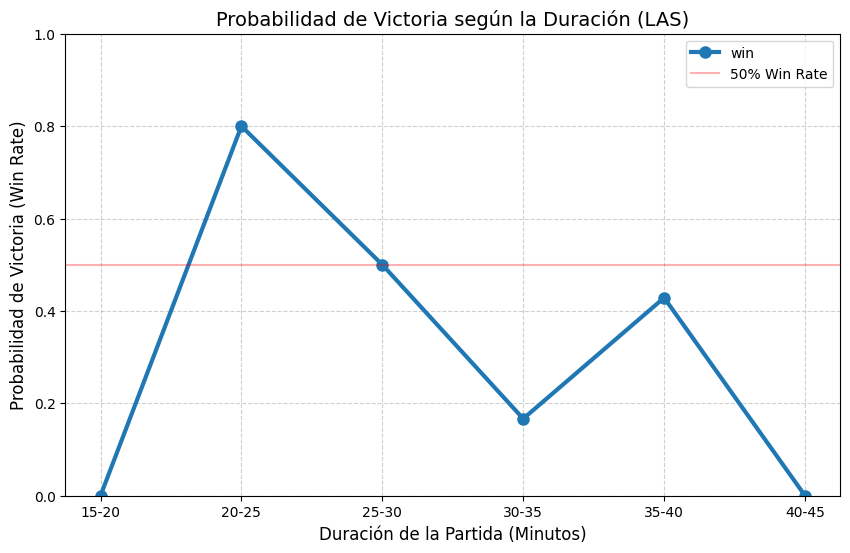

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Creamos los rangos de tiempo (bins) de 5 minutos cada uno
# Desde los 15 min hasta los 50 min
bins = [15, 20, 25, 30, 35, 40, 45, 50]
labels = ['15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50']

# 2. Creamos una nueva columna en el DF con el rango al que pertenece la partida
df['rango_duracion'] = pd.cut(df['duracion_partida'], bins=bins, labels=labels)

# 3. Agrupamos por ese rango y calculamos el promedio de la columna 'win'
# El promedio de una columna de 0s y 1s es exactamente la probabilidad (0.5 = 50%)
win_rate_por_tiempo = df.groupby('rango_duracion')['win'].mean()

# 4. Graficamos
plt.figure(figsize=(10, 6))

# Dibujamos una línea con puntos
win_rate_por_tiempo.plot(kind='line', marker='o', color='#1f77b4', linewidth=3, markersize=8)

# Configuraciones estéticas
plt.title('Probabilidad de Victoria según la Duración', fontsize=14)
plt.xlabel('Duración de la Partida (Minutos)', fontsize=12)
plt.ylabel('Probabilidad de Victoria (Win Rate)', fontsize=12)
plt.ylim(0, 1) # El eje Y siempre de 0 a 100%
plt.grid(True, linestyle='--', alpha=0.6)

# Agregamos una línea horizontal en el 50% como referencia
plt.axhline(y=0.5, color='red', linestyle='-', alpha=0.3, label='50% Win Rate')

plt.legend()
plt.show()

Quiero ver la relacion de hacer athakan con ganar

In [ ]:
#tabla de contingencia
tabla = pd.crosstab(df['team_atakhan'], df['win'], margins=True)
display(tabla)

win,0,1,All
team_atakhan,,,
0,26,8,34
1,6,10,16
All,32,18,50


In [ ]:
# prueba de chi cuadrado
from scipy.stats import chi2_contingency

chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['team_atakhan'], df['win']))
print(f"Valor P: {p}")

Valor P: 0.018167037820082037


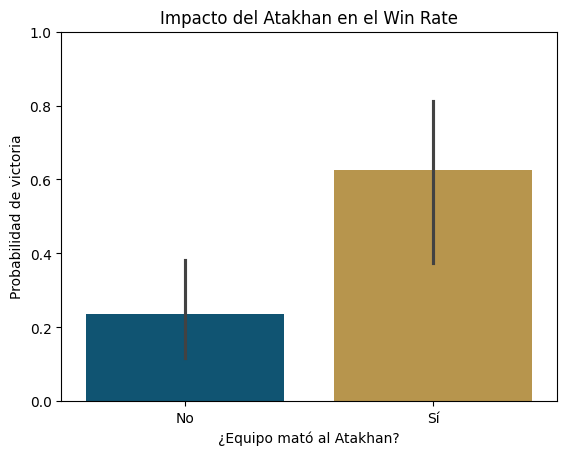

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

mis_colores = [color_azul, color_oro] # Rojo y Verde esmeralda

# Normalizamos para ver porcentajes en lugar de conteos
#tabla_pct = pd.crosstab(df['team_atakhan'], df['win'], normalize='index')
sns.barplot(data=df, x='team_atakhan', y='win', palette=mis_colores, hue='team_atakhan', legend=False)

# Para que el eje Y sea siempre de 0 a 1 (100%)
plt.ylim(0, 1)
plt.title('Impacto del Atakhan en el Win Rate')
plt.xlabel('¿Equipo mató al Atakhan?')
plt.ylabel('Probabilidad de victoria')
plt.xticks([0, 1], ['No', 'Sí'], rotation=0)
plt.show()

Quiero ver la relacion de tener las botas mejoradas con ganar

Quiero ver la relacion de tener 1 baron con ganar

In [ ]:
df['team_baron'].value_counts()

,count
team_baron,
0,41
1,7
2,2


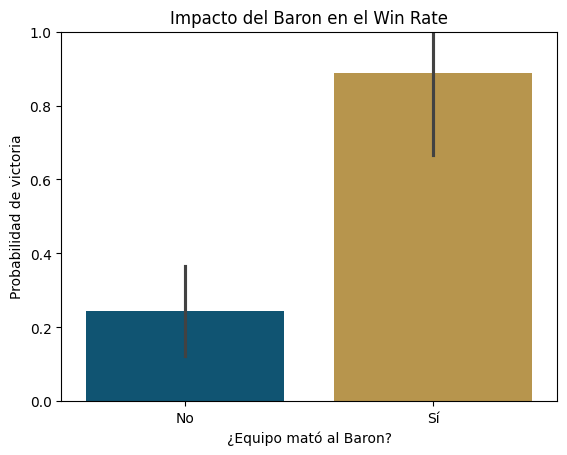

In [ ]:
df['team_baron_bool'] = df['team_baron'].apply(lambda x: 1 if x > 0 else 0)

sns.barplot(data=df, x='team_baron_bool', y='win', palette=mis_colores, hue='team_baron_bool', legend=False)

# Para que el eje Y sea siempre de 0 a 1 (100%)
plt.ylim(0, 1)
plt.title('Impacto del Baron en el Win Rate')
plt.xlabel('¿Equipo mató al Baron?')
plt.ylabel('Probabilidad de victoria')
plt.xticks([0, 1], ['No', 'Sí'], rotation=0)
plt.show()

Quiero ver la relacion de tener alma de dragon con ganar

Win rate segun rol jugado

In [ ]:

cuenta = mis_cuentas[0]
puuid = obtener_puuid_manual(cuenta['nombre'], cuenta['tag'], api_key)

match_ids= watcher.match.matchlist_by_puuid(region_ruteo, puuid, count=10, queue=420)
m_id = match_ids[0]

ejemplo_match = watcher.match.by_id(region_ruteo, m_id)

# 1. ¿Qué hay en la raíz?
print("Raíz:", ejemplo_match.keys())
# Verás: dict_keys(['metadata', 'info'])

# 2. ¿Qué hay dentro de info?
print("Info:", ejemplo_match['info'].keys())
# Verás: 'gameCreation', 'participants', 'teams', 'queueId', etc.

# 3. ¿Qué datos tiene el primer participante?
p0 = ejemplo_match['info']['participants'][0]
print("Datos del participante:", p0.keys())

# 4. ¿Y qué hay en sus desafíos?
print("Desafíos:", p0.get('challenges', {}).keys())

Raíz: dict_keys(['metadata', 'info'])
Info: dict_keys(['endOfGameResult', 'gameCreation', 'gameDuration', 'gameEndTimestamp', 'gameId', 'gameMode', 'gameName', 'gameStartTimestamp', 'gameType', 'gameVersion', 'mapId', 'participants', 'platformId', 'queueId', 'teams', 'tournamentCode'])
Datos del participante: dict_keys(['PlayerScore0', 'PlayerScore1', 'PlayerScore10', 'PlayerScore11', 'PlayerScore2', 'PlayerScore3', 'PlayerScore4', 'PlayerScore5', 'PlayerScore6', 'PlayerScore7', 'PlayerScore8', 'PlayerScore9', 'allInPings', 'assistMePings', 'assists', 'baronKills', 'basicPings', 'challenges', 'champExperience', 'champLevel', 'championId', 'championName', 'championTransform', 'commandPings', 'consumablesPurchased', 'damageDealtToBuildings', 'damageDealtToEpicMonsters', 'damageDealtToObjectives', 'damageDealtToTurrets', 'damageSelfMitigated', 'dangerPings', 'deaths', 'detectorWardsPlaced', 'doubleKills', 'dragonKills', 'eligibleForProgression', 'enemyMissingPings', 'enemyVisionPings', 'f

In [ ]:
print(ejemplo_match['info']['totalTimeSpentDead'])
['challenges']['controlWardsPlaced']
'dodgeSkillShotsSmallWindow'
'earlyLaningPhaseGoldExpAdvantage'
 'firstTurretKilled'
 'laningPhaseGoldExpAdvantage'
 'outnumberedKills'
 'saveAllyFromDeath'
 'skillshotsDodged'
 'soloKills'
 'twentyMinionsIn3SecondsCount'

GameComplete
